In [1]:
import numpy as np
from scipy import ndimage, fft, stats
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import time

In [2]:
PLOT_RESULTS = True
RADIUS = 30
STD = 5
DPI=120

## 1.1 Fourier transformation

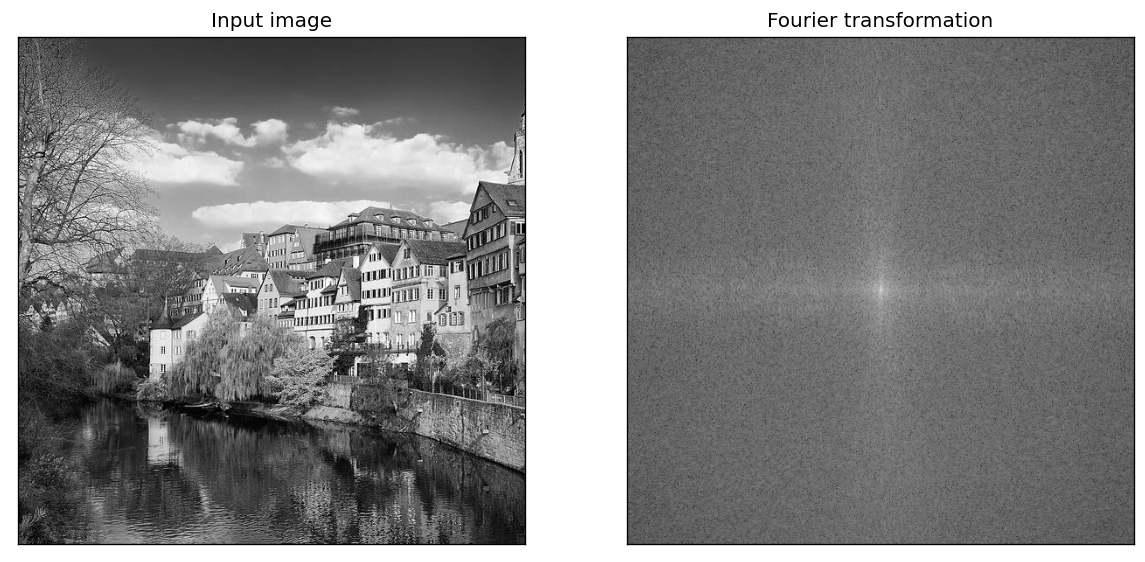

In [3]:
# ----- load the input image

img = imread('inputs/tuebingen.jpg')[:, :, 1] / 255.  
img_size = img.shape[0]


# TODO
FT_img_log = np.log10(np.abs(fft.fftshift(fft.fft2(img)))) # spectrum, shift low freq to center

## absolute number needed to get magnitude from complex number
## log because improving contrast

# ----- plot input image together with fourier transformation
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, cmap = 'gray')
    plt.title('Input image')

    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(FT_img_log, cmap='gray') ## smaller values result in more contrast
    plt.title('Fourier transformation')
    plt.show()


## 1.2 High-pass filter in spectral space

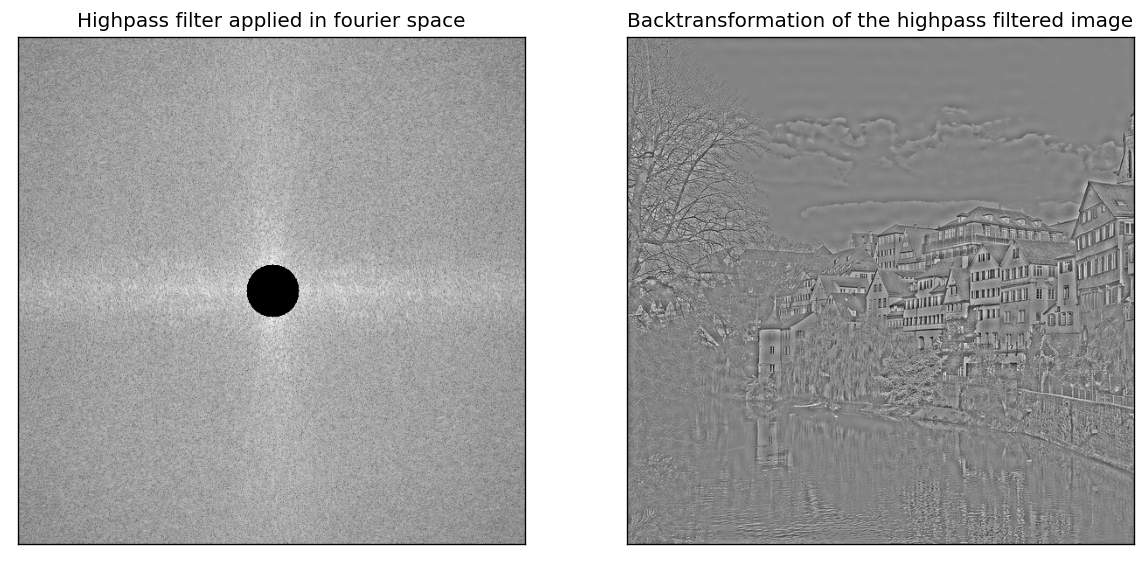

In [4]:
# TODO
def highpass_filter(img_size, radius):
    
    ''' Returns a highpass filter.
    input:
        img_size: length of the filter
        redius: radius of the circular aperture
    output:
        highpass: a filter of size(img_size, img_size) with values zero and one
    '''
    
    x = np.arange(-img_size//2, img_size//2)
    xx, yy = np.meshgrid(x, x)
    
    # Calculate distances from the center
    distances = np.sqrt(xx**2 + yy**2)
    
    # Create the filter
    highpass = np.where(distances <= radius, 0, 1)
           
    return highpass

# TODO
# step 2: apply filter (with radius 30) to the spectrum
highpass = highpass_filter(img_size, radius=RADIUS)

spectrum = fft.fftshift(fft.fft2(img))
# TODO
# step 3: transform the spectrum back to image space
filtered_spectrum = spectrum * highpass

img_filtered = fft.ifft2(fft.ifftshift(filtered_spectrum)).real 
# real because of image space with inverse transform because started normally                 

if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(filtered_spectrum)**0.15, cmap = 'gray')   # Potenz dient der Kontrastanpassung
    plt.title('Highpass filter applied in fourier space')


    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_filtered), cmap=plt.cm.gray)
    plt.title('Backtransformation of the highpass filtered image')
    plt.show()


## 1.3 Gaussian filter

### 1.3.1 Construct a Gaussian filter

In [5]:
# TODO
def g_kern(kernlen=5, std=1):
    ''' Returns a 2D Gaussian kernel with standard deviation std
    input:
        kernlen: length of the filter
        std: standard deviation of the Gaussian in pixels
    output:
        g_kern_2d: a Gaussian kernel of size (kernlen, kernlen) with sum 1
    '''
    center = (kernlen - 1) / 2
    x = np.arange(kernlen) - center
    y = x[:, np.newaxis]
    
    weights = stats.norm.cdf(x + 0.5, scale=std) - stats.norm.cdf(x - 0.5, scale=std)
    
    g_kern_2d = weights * weights[:, np.newaxis]
    g_kern_2d /= np.sum(g_kern_2d)
    
    return g_kern_2d


### 1.3.2 Apply Gaussian filter in image space

In [6]:
# TODO
#   step 2: create such a gaussian filter with standard deviation 3 and filtersize 25 and
#           convolve the image with this filter 
gaussfilter_img = g_kern(img_size, std=5)
img_conv = ndimage.convolve(img, g_kern(30,5))


### 1.3.3 Transform the Gaussian filter to fourier space

In [7]:
# TODO
#   step 3: transform the gaussian kernel to fourier space
gaussfilter_f = fft.fft2(gaussfilter_img)
gaussfilter_f_shift = fft.fftshift(gaussfilter_f)

### 1.3.4 Apply this filter in fourier space

In [8]:
f_gauss = abs(gaussfilter_f) * (fft.fft2(img))
img_gauss_f = abs(fft.ifft2(f_gauss))

### 1.3.5. Visuallise and compare two filtering methods

difference: 0.005488654026627061


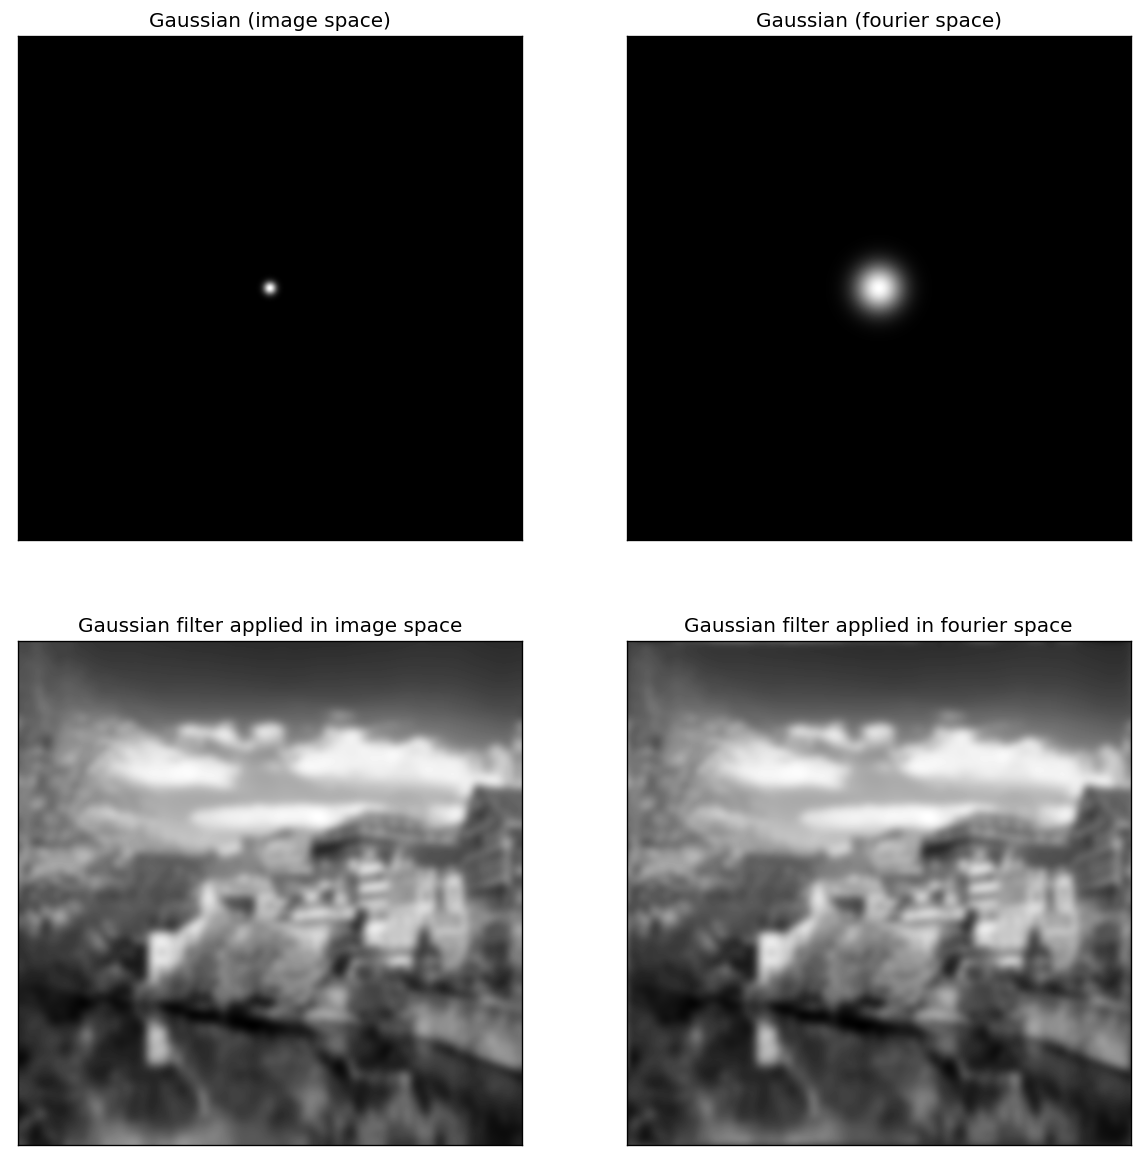

In [9]:
#   step 5: compare the results
difference = np.mean(np.abs(img_gauss_f - img_conv))       
print('difference: ' + str(difference))

if PLOT_RESULTS:
    # compare the two images
    plt.figure(figsize=(12, 12),dpi=DPI)

    plt.subplot(221)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((gaussfilter_img), cmap=plt.cm.gray)
    plt.title('Gaussian (image space)')
    plt.subplot(222)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(gaussfilter_f_shift), cmap=plt.cm.gray)
    plt.title('Gaussian (fourier space)')
    plt.subplot(223)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      # img_conv
    plt.title('Gaussian filter applied in image space')
    plt.subplot(224)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_gauss_f), cmap=plt.cm.gray)
    plt.title('Gaussian filter applied in fourier space')
    plt.show()


### 1.3.6 Splitted convolutional filter

difference: 0.0022811982460799146


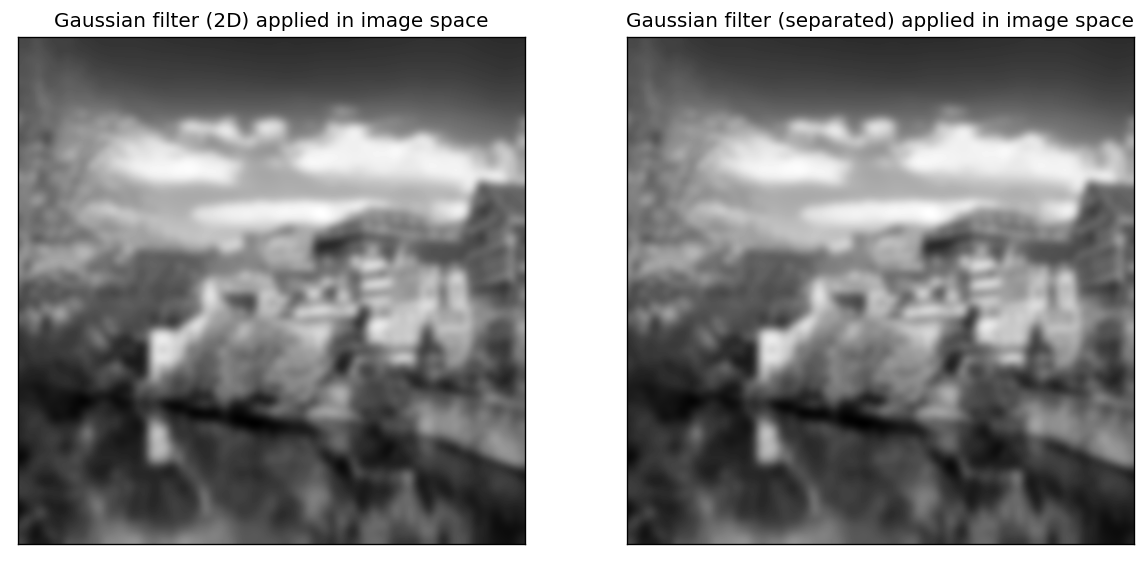

In [10]:
# TODO
def g_kern1d(kernlen=5, std=1):
    '''
    Returns a 1D Gaussian kernel with standard devitation sig 
    input:
        kernlen: length of the filter std: standard deviation of the gaussian in  pixels 
    output: 
        g_kern_1d: a gaussian kernel of size (kernlen, 1)
    '''
    g_kern_1d = np.zeros((kernlen, 1))

    for i in range(kernlen):
        g_kern_1d[i] = stats.norm.pdf(abs(i - ((kernlen - 1)/2)), loc=0, scale=std) 
    return g_kern_1d

gaussfilter_img_1D = g_kern1d(30, 5)
img_conv_sep_final = ndimage.convolve(ndimage.convolve(img, gaussfilter_img_1D), gaussfilter_img_1D.T)

difference = np.mean(np.abs(img_conv_sep_final - img_conv))       
print('difference: ' + str(difference))

# ----- plot results
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      
    plt.title('Gaussian filter (2D) applied in image space')
    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img_conv_sep_final, cmap='gray')
    plt.title('Gaussian filter (separated) applied in image space')
    plt.show()


In [11]:
#calculate execution time of seperated and combined gaussian filter
n_time_comb = np.zeros((50, 1))
for i in range(50):
    start = time.time()
    bla = ndimage.convolve(img, g_kern(30, 5))
    n_time_comb[i] = time.time() - start
print('combined execution time: {:.4f}s'.format(np.mean(n_time_comb)))

n_time_sep = np.zeros((50, 1))
for i in range(50):
    start = time.time()
    blabla = ndimage.convolve(ndimage.convolve(img, g_kern1d(30, 5)), g_kern1d(30, 5).T)
    n_time_sep[i] = time.time() - start
print('seperated execution time: {:.4f}s'.format(np.mean(n_time_sep)))

combined execution time: 0.2838s
seperated execution time: 0.0156s
